# RNN Activity: Predicting the stock market
![](https://imgs.xkcd.com/comics/marketwatch.png)

Note: I do not recommend making any kind of financial decisions based on RNNs.

## Setup
To fetch the data, we'll need the `yfinance` package. Activate your virtual environment, then run `pip install yfinance`.

In [40]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
# feel free to play around with different ticker values
ticker = "BTC-USD"
description = "Bitcoin"

# get the data for the last 10 years. This is daily data by default, so it's not actually that much.
data = yf.download(ticker, period="10y")

import matplotlib.pyplot as plt

plt.plot(data['Close'])
plt.ylabel(f'{description} Closing Price (USD)')
plt.xticks(rotation=45)
plt.show()

data.head()

## Split the data into training and testing sets
Pandas is pretty smart with dates, so we can use the date as an index. Let's keep 2023 as our test set and choose 2022 as validation.

In [32]:
train_val = '2021-12-31'
val_test = '2022-12-31'

train = data['Close'][:train_val]
val = data['Close'][train_val:val_test]
test = data['Close'][val_test:]

In [58]:
# And prepare for RNN
window = 7

# try using the last 7 days as input to predict the next day
def to_ds(data, input_width, batch_size=32):
    input_data = data[:-input_width]
    targets = data[input_width:]
    return tf.keras.utils.timeseries_dataset_from_array(
        input_data, 
        targets, 
        sequence_length=input_width,
        batch_size=batch_size)

train_ds = to_ds(train, window)
val_ds = to_ds(val, window)
test_ds = to_ds(test, window)

In [66]:
# Start with a single layer RNN
simple_RNN = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=[None, 1], activation='relu'),
    tf.keras.layers.Dense(1),
])

metrics = [
    tf.keras.metrics.MeanAbsoluteError(),
]

simple_RNN.compile(optimizer='adam', loss='mse', metrics=metrics)
history = simple_RNN.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
83/83 [==============================] - 1s 9ms/step - loss: 454387040.0000 - mean_absolute_error: 12534.1191 - val_loss: 1014094976.0000 - val_mean_absolute_error: 30004.7969
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 352172992.0000 - mean_absolute_error: 10661.6465 - val_loss: 825959104.0000 - val_mean_absolute_error: 27074.3965
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 292203520.0000 - mean_absolute_error: 9718.5635 - val_loss: 674893504.0000 - val_mean_absolute_error: 24468.6992
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 219660352.0000 - mean_absolute_error: 8478.7393 - val_loss: 468089632.0000 - val_mean_absolute_error: 20362.5430
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 102587344.0000 - mean_absolute_error: 5935.5591 - val_loss: 146291104.0000 - val_mean_absolute_error: 11310.0898
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - 

(0.0, 2000.0)

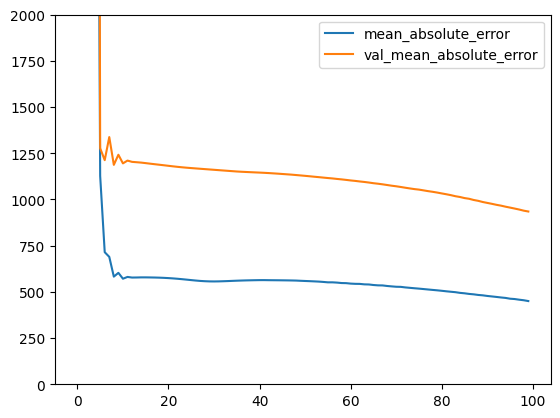

In [79]:
# plot the training curve
pd.DataFrame(history.history)[['mean_absolute_error', 'val_mean_absolute_error']].plot()
plt.ylim(0, 2000)

14/14 [==============================] - 0s 8ms/step


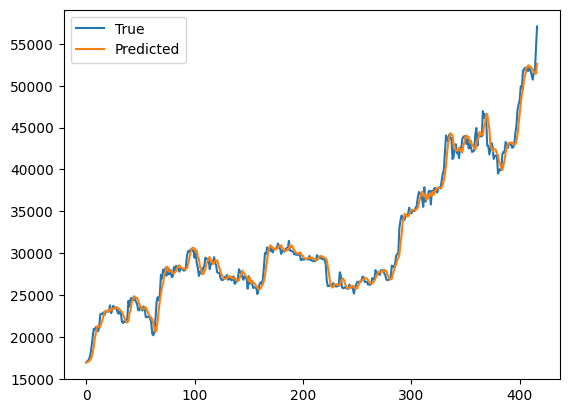

In [101]:
# Predict on the test set and see how well it does
predictions = simple_RNN.predict(test_ds)

# Note: pandas is smart enough to show the dates, so getting .values allows
# us to align with the predictions a bit better
plt.plot(test.values[window:-window+1], label='True')
plt.plot(predictions.flatten(), label='Predicted')
plt.legend()

## Exercises and Questions
1. Can you improve the model? Try playing around with layers, units, activation functions, etc
2. Why does it look okay when you overlay the predictions, but the MAE is so high?
3. Can you modify the model to try to predict the **direction** of the stock instead of the price (i.e. up or down)?
4. Can you modify the model to make it predict X days in the future instead of just 1?